Conducting anomaly detection and removing anomalies on the train data and test data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import random

TEMP_LOW_LIMIT = -459.67
TEMP_HIGH_LIMIT = 1000
RPM_LOW_LIMIT = 0
RPM_HIGH_LIMIT = 6e8  # the largest achieved rpm of all human artifacts
Y_LIMS = {
    'rpm': (-20, 1500),
    'motor_voltage': (0, 400),
    'motor_current': (-20, 100),
    'motor_temp': (-20, 250),
    'inlet_temp': (-20, 250),
}

First remove some unreal data points (physically impossible temperature, rpm, etc.)

In [2]:
def exclude_physical_anml(df):
    result = df[(df['motor_temp'] > TEMP_LOW_LIMIT) & (df['inlet_temp'] > TEMP_LOW_LIMIT) & (df['rpm'] > 0) & (df['rpm'] < RPM_HIGH_LIMIT)]
    return result

def exclude_anomalies(df, thresholds):
    result = df
    for feature in thresholds:
        low_limit, high_limit = thresholds[feature]
        result = result[(result[feature] > low_limit) & (result[feature] < high_limit)]
    return result

def plot_feature_in_df(unit, feature_name, bins=20):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    df_unit = pd.read_csv("../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit_name), index_col=0)
    df_unit['timestamp'] = pd.to_datetime(df_unit['timestamp'])
    sns.set()
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    ax1 = fig.add_subplot(211)
    ax1.title.set_text(feature_name)
    df_unit.set_index('timestamp', inplace=True)
    df_unit[feature_name].plot(ylim=Y_LIMS[feature_name], label=feature_name)
        
    # plot warnings and errors
    df_alarm = pd.read_csv("../data/raw/train/unit{}_alarms.csv".format(unit_name), header=None, names=['timestamp', 'warning'])
    df_alarm['timestamp'] = pd.to_datetime(df_alarm['timestamp'])
    df_alarm.set_index('timestamp', inplace=True)
    warning_x = df_alarm[df_alarm['warning'] == 'warning'].index.values
    error_x = df_alarm[df_alarm['warning'] == 'error'].index.values
    for warning in warning_x:
        plt.axvline(x=warning, color='orange', alpha=0.3, label='warning')
    for error in error_x:
        plt.axvline(x=error, color='red', alpha=0.7, label='error')
    #plt.legend()
    ax2 = fig.add_subplot(212)
    sns.distplot(df_unit[feature_name], bins=bins)
    ax2.title.set_text(feature_name)
    plt.show()
    
def peek_attributes_trend(attribute):
    units = ["000{}".format(num) if num < 10 else "00{}".format(num) for num in random.sample(range(0, 20), 9)]
    file_names = ["../data/raw/train/unit{}_rms.csv".format(unit) for unit in units]
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, file_name in enumerate(file_names):
        file_df = pd.read_csv(file_name)
        file_df = exclude_physical_anml(file_df)
        ax1 = plt.subplot(3, 3, idx + 1)
        file_df[attribute].plot(ylim=Y_LIMS[attribute])
    plt.show()

Take a look at some value distributions of the rpm in different units 

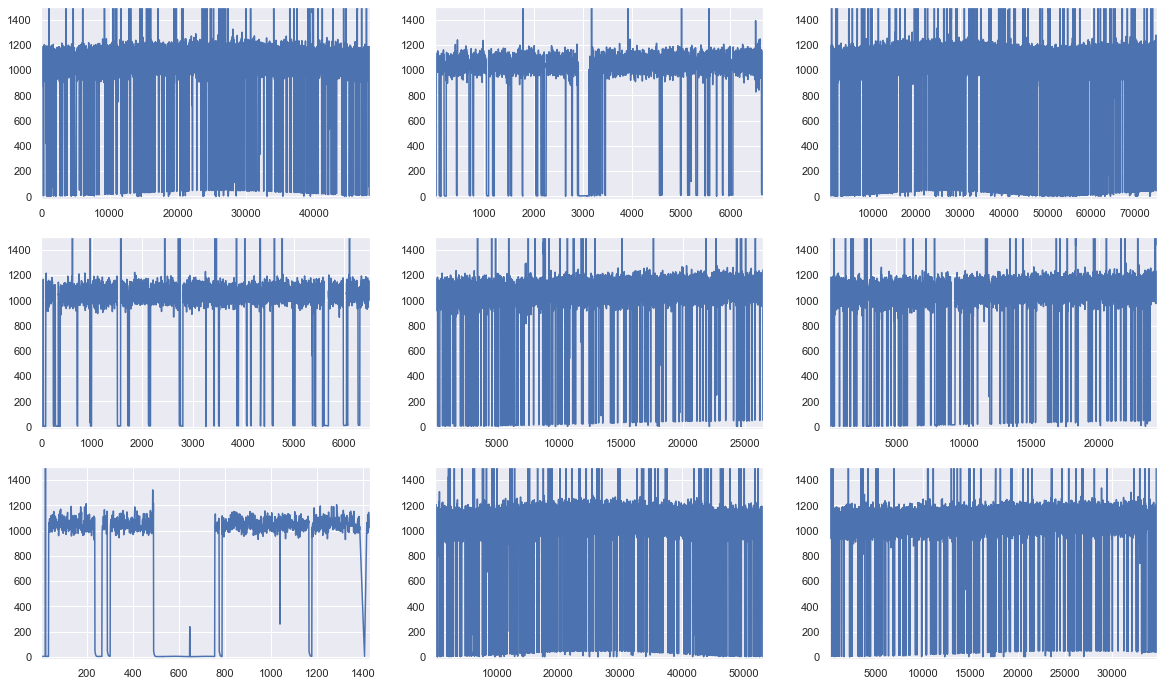

In [43]:
peek_attributes_trend('rpm')

Anomaly detection using boxplot

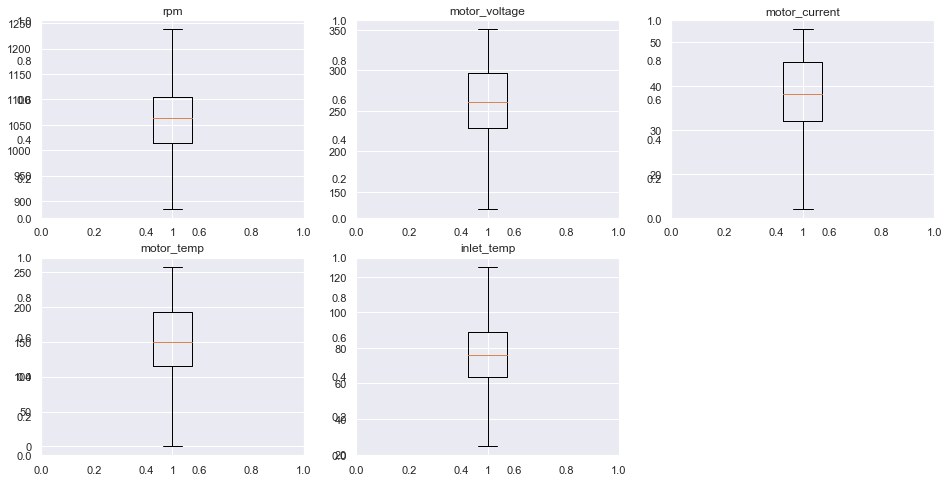

In [22]:
df_1 = pd.read_csv("../data/raw/train/unit0001_rms.csv")
df_1 = exclude_physical_anml(df_1)
feature_names = df_1.columns[1:].tolist()
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[1][2].set_visible(False)
thresholds = {}
for idx, feature in enumerate(feature_names):
    ax = fig.add_subplot(2, 3, idx + 1)
    bp = ax.boxplot(df[feature], 0, '')
    values = [item.get_ydata() for item in bp['whiskers']]
    thresholds[feature] = (values[0][1], values[1][1])
    ax.title.set_text(feature)

df_by_bp = exclude_anomalies(df, thresholds)

Excluding anomalies detected by boxplot in all units.

In [21]:
def exclude_anml_on_all_units(anml_func, folder='train'):
    unit_range = range(0, 20) if folder == 'train' else range(20, 50)
    for unit in unit_range:
        unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
        print("handling {}".format(unit_name))
        df_unit = pd.read_csv('../data/raw/{}/unit{}_rms.csv'.format(folder, unit_name))
        
        # configuring thresholds by boxplot
        df_unit = exclude_physical_anml(df_unit)
        feature_names = df_unit.columns[1:].tolist()
        thresholds = {}
        for feature in feature_names:
            bp = plt.boxplot(df_unit[feature], 0, '')
            values = [item.get_ydata() for item in bp['whiskers']]
            thresholds[feature] = (values[0][1], values[1][1])
            plt.close()
        
        df_anml_excluded = anml_func(df_unit, thresholds)
        df_anml_excluded.to_csv("../data/processed/{}/unit{}_rms_anomaly_excluded.csv".format(folder, unit_name))

In [22]:
exclude_anml_on_all_units(exclude_anomalies, folder='train')

handling 0000
handling 0001
handling 0002
handling 0003
handling 0004
handling 0005
handling 0006
handling 0007
handling 0008
handling 0009
handling 0010
handling 0011
handling 0012
handling 0013
handling 0014
handling 0015
handling 0016
handling 0017
handling 0018
handling 0019


In [35]:
exclude_anml_on_all_units(exclude_anomalies, folder='test')

handling 0020
handling 0021
handling 0022
handling 0023
handling 0024
handling 0025
handling 0026
handling 0027
handling 0028
handling 0029
handling 0030
handling 0031
handling 0032
handling 0033
handling 0034
handling 0035
handling 0036
handling 0037
handling 0038
handling 0039
handling 0040
handling 0041
handling 0042
handling 0043
handling 0044
handling 0045
handling 0046
handling 0047
handling 0048
handling 0049


Plot features value trend of unit 0001 after excluding anomalies, combining the occurrences of warnings and errors

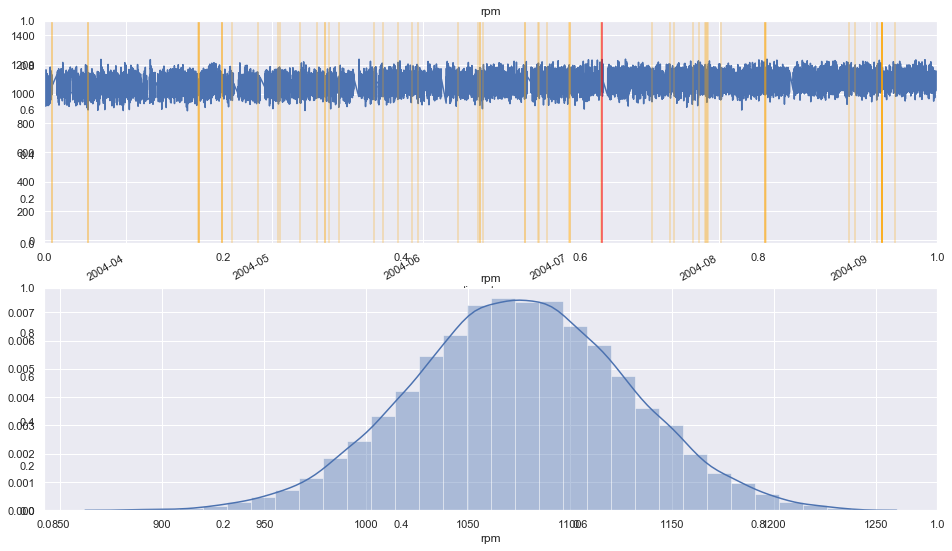

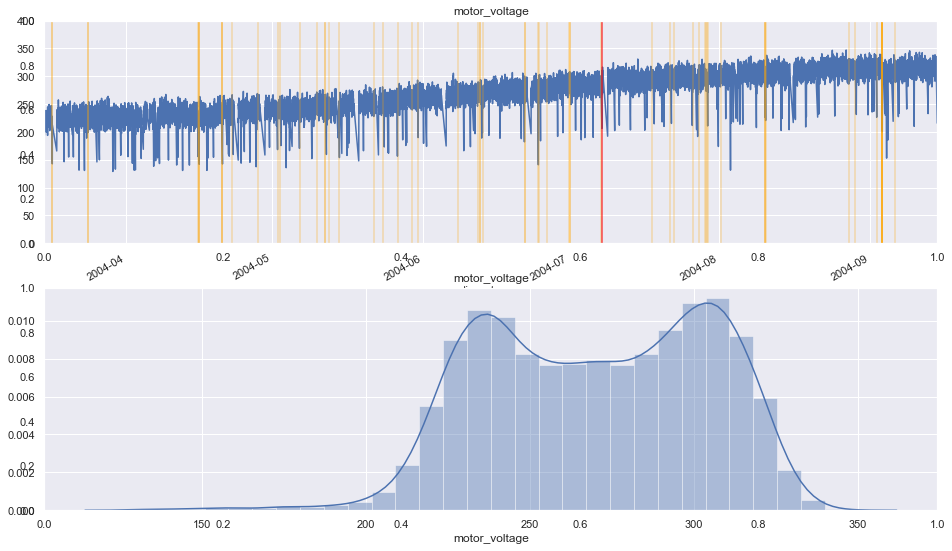

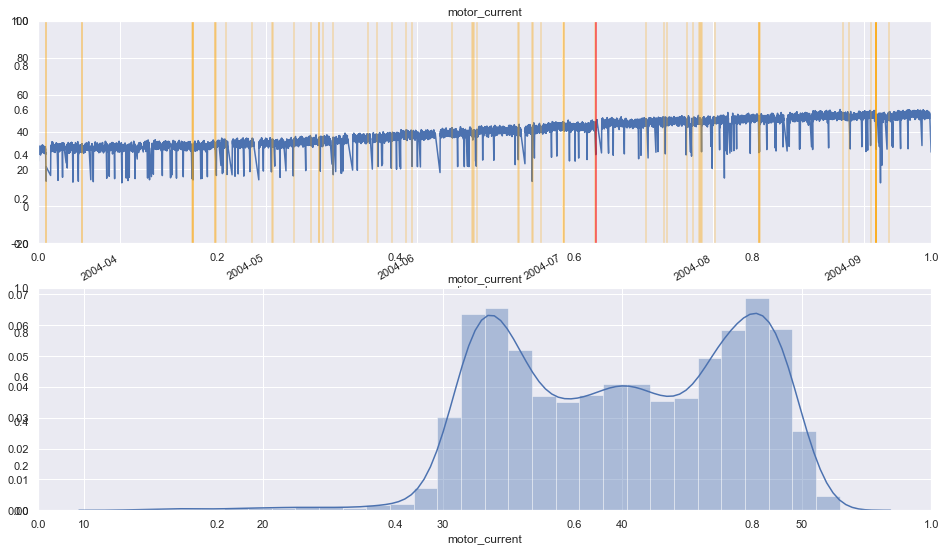

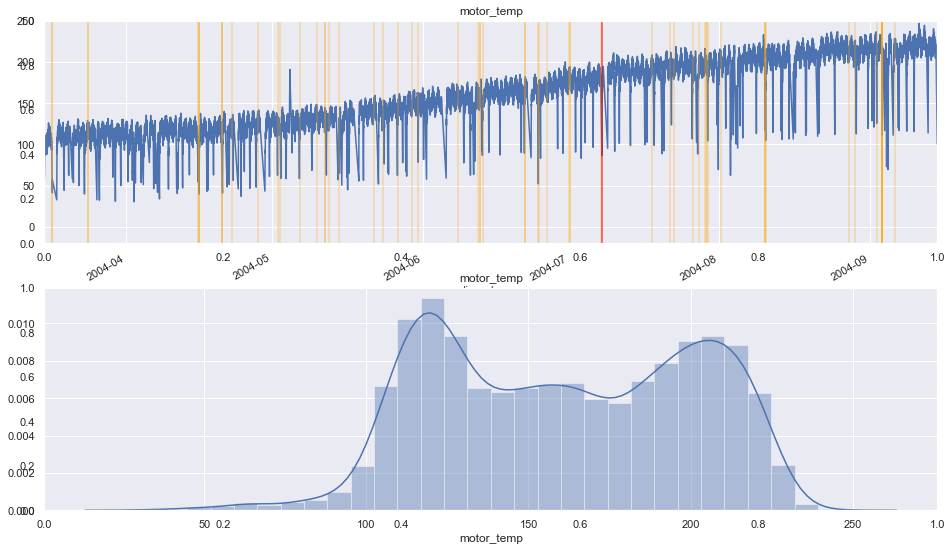

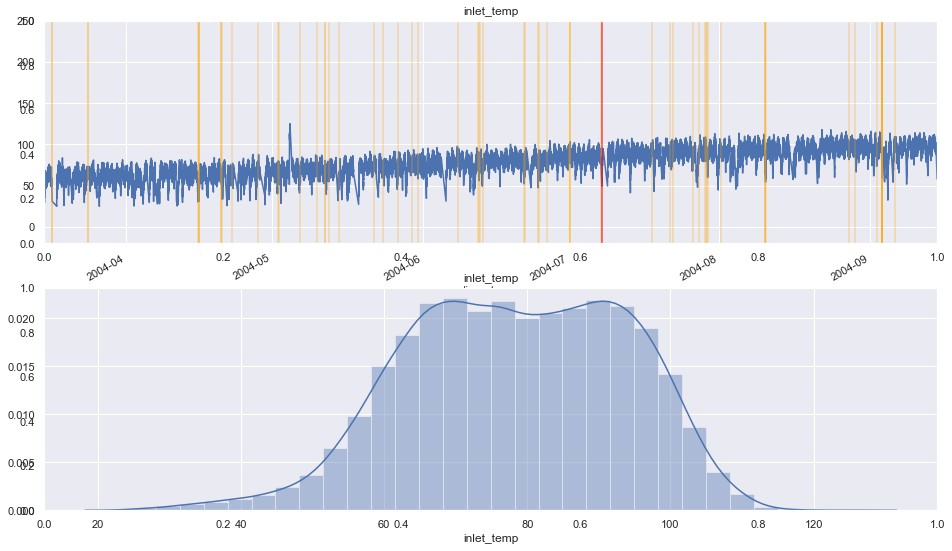

In [4]:
def plot_features_in_df(unit):
    plot_feature_in_df(unit, 'rpm',  bins=30)
    plot_feature_in_df(unit, 'motor_voltage',  bins=30)
    plot_feature_in_df(unit, 'motor_current',  bins=30)
    plot_feature_in_df(unit, 'motor_temp',  bins=30)
    plot_feature_in_df(unit, 'inlet_temp',  bins=30)

plot_features_in_df(1)

Try to detecting anomaly using isolation forest

First log the feature values

In [127]:
df = pd.read_csv("../data/raw/train/unit0001_rms.csv")
df_log = np.log(df[df.columns[1:]]).replace(0, 0.01).replace(np.nan, 0.01)
df_log

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
0,0.010000,0.010000,0.010000,1.620911,-4.560839
1,-1.506703,-0.256209,-3.608043,1.959417,0.732362
2,-0.469674,0.431026,-1.366025,2.213815,1.360201
3,0.215639,0.837285,-1.329597,2.377841,1.693965
4,0.358221,1.079252,-0.369009,2.532900,1.971482
...,...,...,...,...,...
26455,3.865396,4.559207,2.948665,4.606219,4.060833
26456,3.865472,4.559227,2.957204,4.609038,4.057186
26457,3.864375,4.559056,2.948170,4.608095,4.057566
26458,3.868296,4.559594,2.951372,4.606625,4.061846


Use isolation forest to detect anomalies on unit 0001

In [161]:
def transform_column(df_input):
    num_features = df_input.columns[1:]
    num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features)
    ])
    np_pipelined = full_pipeline.fit_transform(df_input)
    df_pipelined = pd.DataFrame(np_pipelined, index=df_input.index)
    return df_pipelined

def log_df(df_input):
    df_log = np.log(df_input)
    return df_log

df = pd.read_csv("../data/raw/train/unit0001_rms.csv")
def train_isolation_forest(df_input, outliers_fraction=0.1):
    IF_model = IsolationForest(contamination=outliers_fraction, n_estimators=200, verbose=1)
    df_log = np.log(df_input[df.columns[1:]]).replace(np.nan, 0.01)

    IF_model.fit(df_log)
    df_with_prediction_IF = df_input.copy()
    print("Isolation forest trained, making predictions...")
    df_with_prediction_IF['is_normal'] = pd.Series(IF_model.predict(df_log), index=df_input.index)
    print("predictions done")
    return df_with_prediction_IF

df_with_prediction_IF = train_isolation_forest(df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


Isolation forest trained, making predictions...
predictions done


Plot feature value trend of unit 0001 after excluding anomalies detected by isolation forest

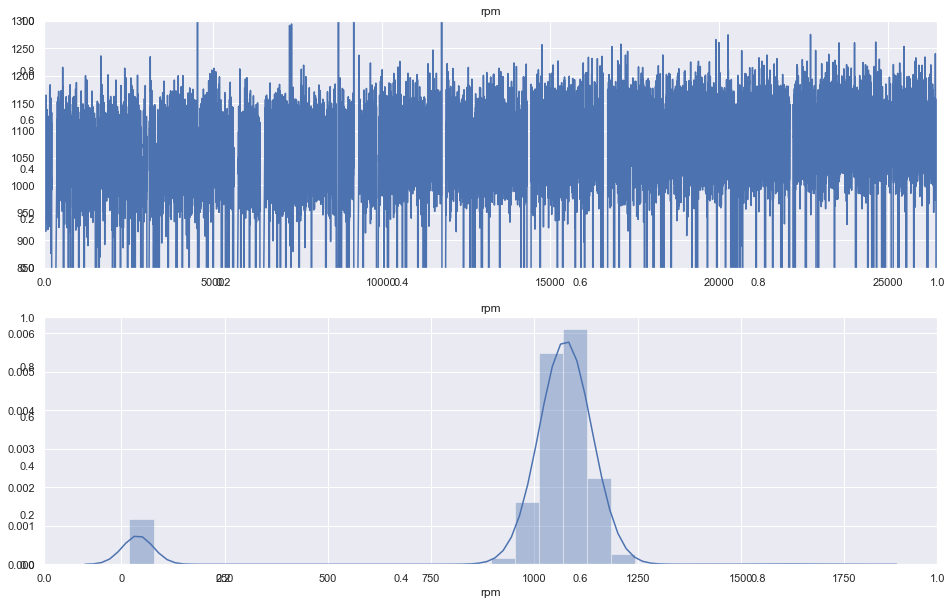

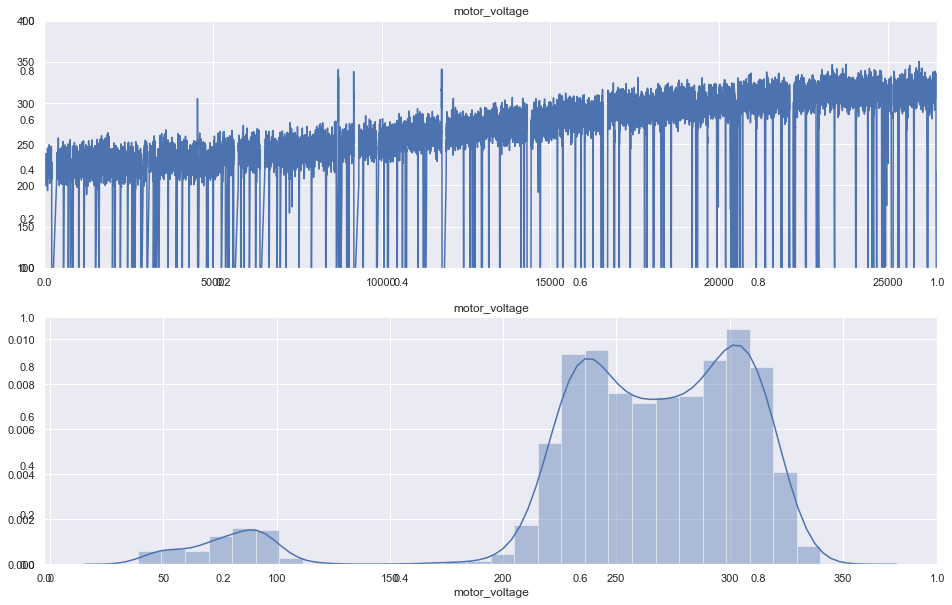

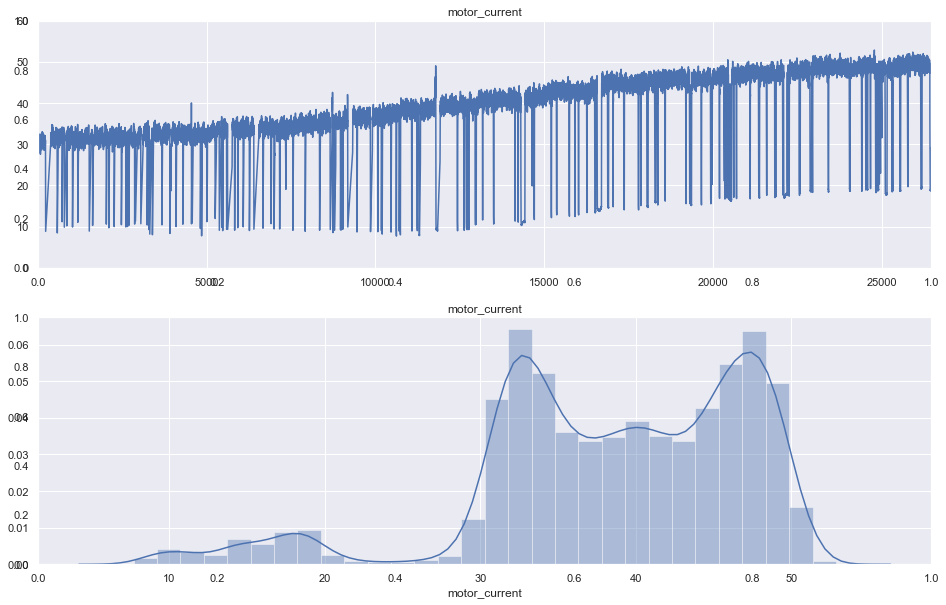

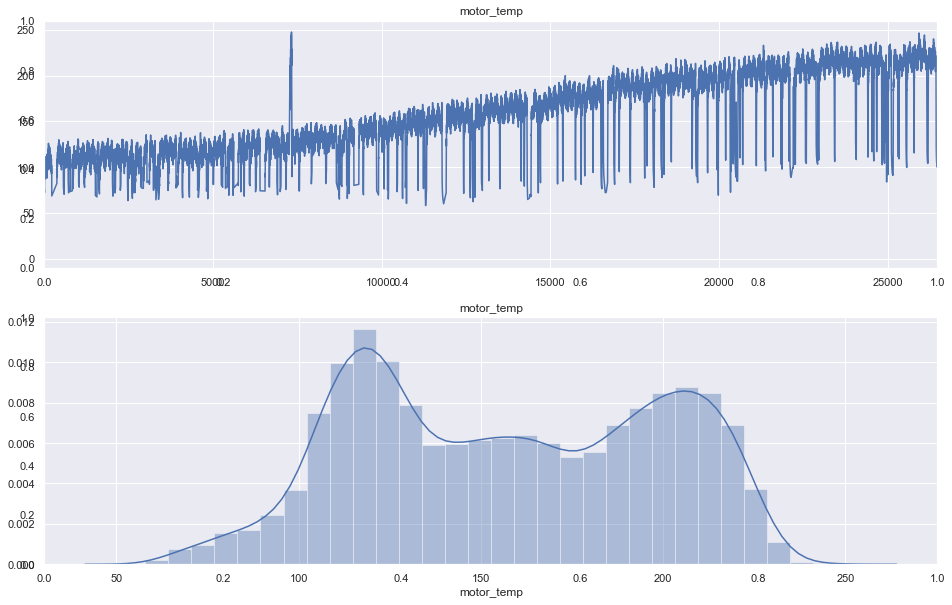

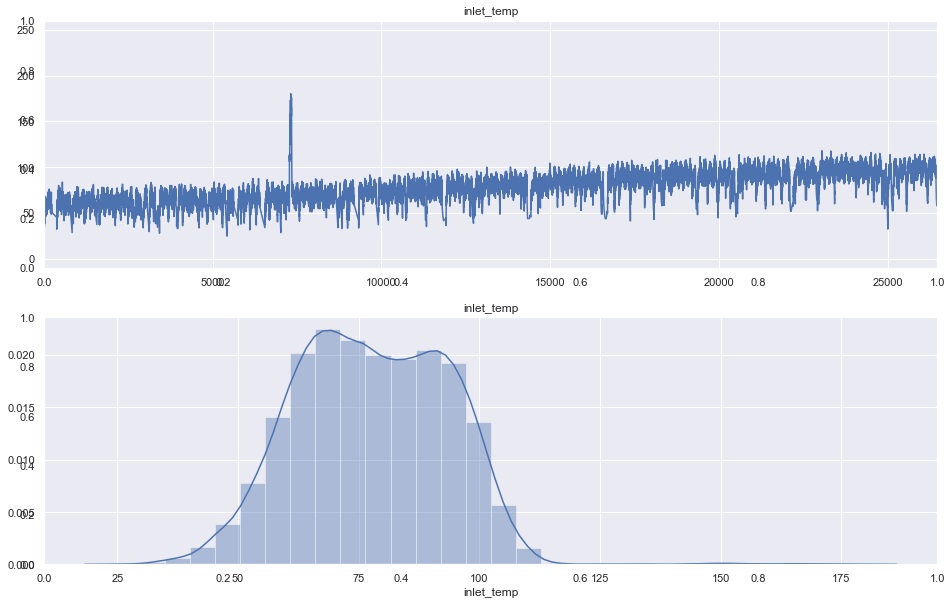

In [160]:
df_by_IF = df_with_prediction_IF[df_with_prediction_IF['is_normal'] == 1]
plot_features_in_df(df_by_IF)

Compared to boxplot, isolation forest tends to keep more outliers for every feature.

Try to take a look at the feature value trends among various units after excluding anomalies using boxplot.

In [179]:
def peek_attributes_trend(attribute, ylim_low=-10, ylim_high=1500):
    units = ["000{}".format(num) if num < 10 else "00{}".format(num) for num in random.sample(range(0, 20), 9)]
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, unit in enumerate(units):
        file_name = "../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit)
        file_df = pd.read_csv(file_name)
        ax1 = plt.subplot(3, 3, idx + 1)
        ax1.set_title("unit {}".format(unit))
        file_df[attribute].plot(ylim=(ylim_low, ylim_high))
    plt.show()

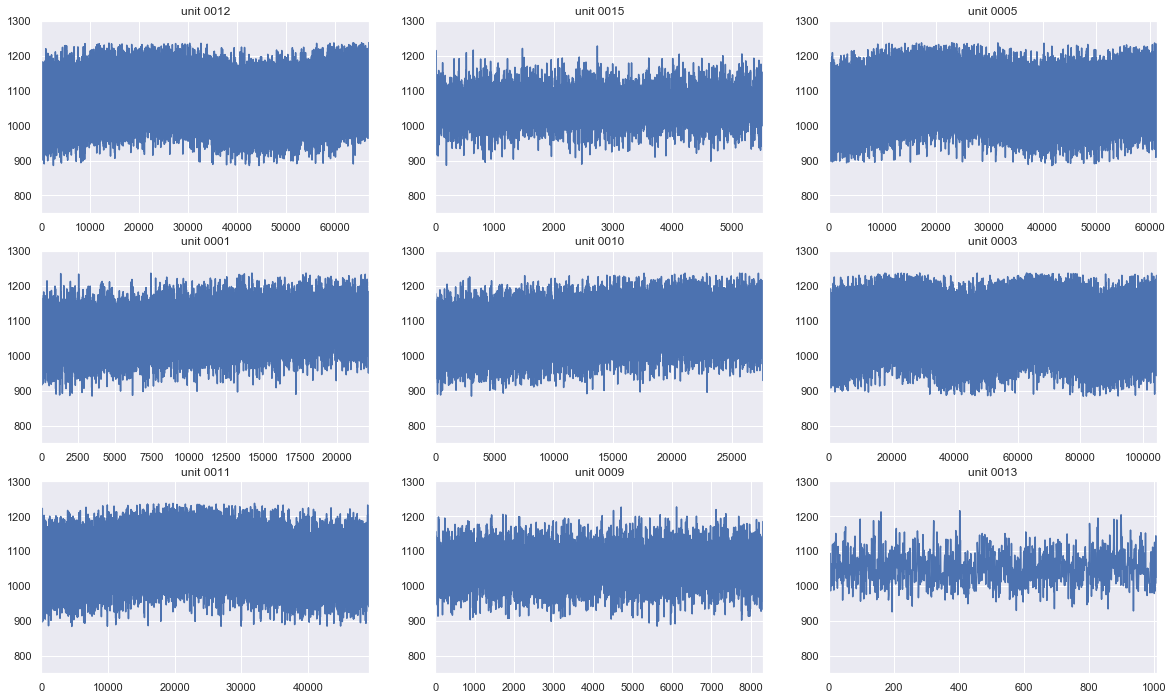

In [180]:
peek_attributes_trend('rpm', ylim_low=750, ylim_high=1300)

Plot the difference between before exlcuding anomalies and after exlcuding anomalies. Mostly of the outliers are removed and the patterns look more concentrated.

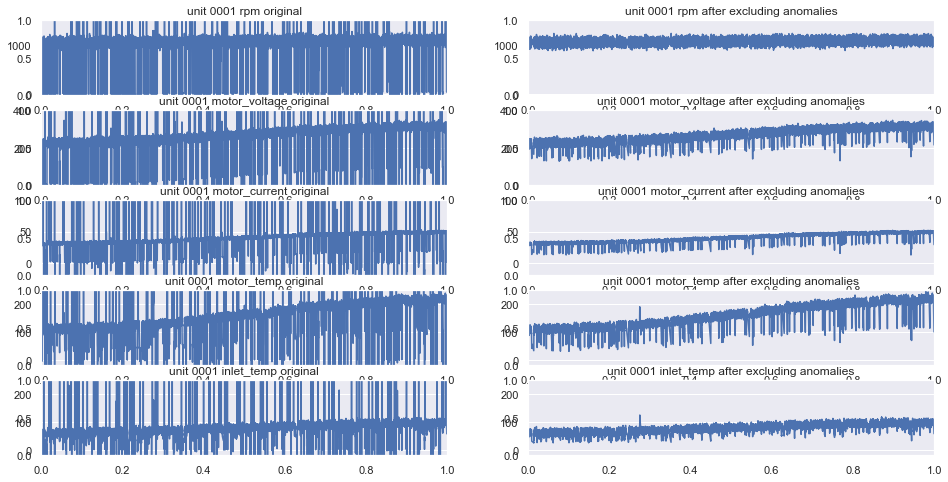

In [36]:
def diff_anml(unit):
    folder = 'train' if unit < 20 else 'test'
    fig, axs = plt.subplots(5, 2, figsize=(16, 8))
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    df_before = pd.read_csv("../data/raw/{}/unit{}_rms.csv".format(folder, unit_name), index_col=0)
    df_after = pd.read_csv("../data/processed/{}/unit{}_rms_anomaly_excluded.csv".format(folder, unit_name), index_col=0)
    features = df_before.columns
    for idx, feature in enumerate(features):
        #lim_low, lim_high = Y_LIMS[feature]
        ax1 = fig.add_subplot(5, 2, idx * 2 + 1)
        df_before[feature].plot(ylim=Y_LIMS[feature])
        ax1.set_title("unit {} {} original".format(unit_name, feature))
        ax1.get_xaxis().set_visible(False)
        ax2 = fig.add_subplot(5, 2, idx * 2 + 2)
        df_after[feature].plot(ylim=Y_LIMS[feature])
        ax2.set_title("unit {} {} after excluding anomalies".format(unit_name, feature))
        ax2.get_xaxis().set_visible(False)
diff_anml(1)

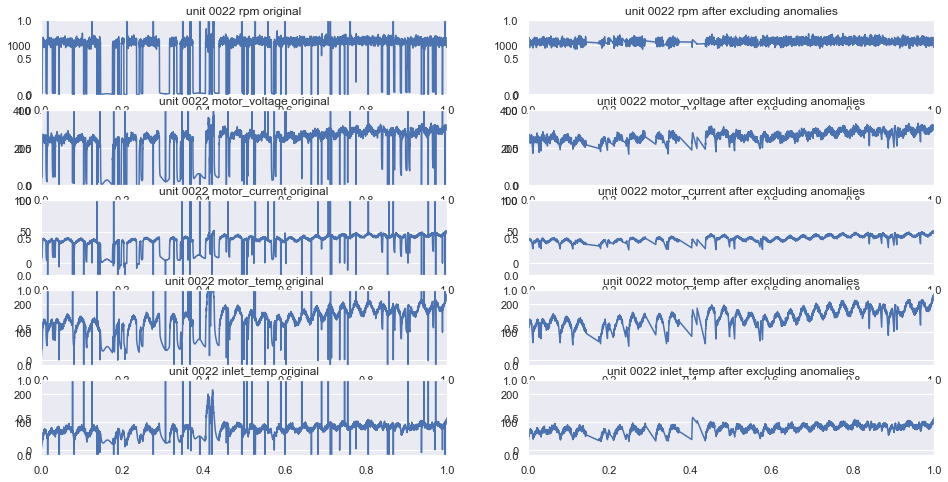

In [37]:
diff_anml(22)

The unit data files with anomalies excluded are saved for further modeling.